We use the Heston Model, under which the underlying follow the following stochastic differential equation :
\begin{align*}
    dS_t &= rS_tdt +\sqrt{V_t}S_tdW_t^1\\
    dV_t &= \kappa(\theta-V_t)dt+\sigma\sqrt{V_t}dW_t^2.
\end{align*}
To simulate numerically this stochastic differential equation, we use the Euler Scheme under which we have
\begin{align*}
    \bar{S}_{t_{k+1}}^{m,i}& = \bar{S}_{t_{k}}^{m,i}+r\bar{S}_{t_{k}}^{m,i}\Delta t + \bar{S}_{t_{k}}^{m,i}\sqrt{\bar{V}_{t_{k}}^{m,i}}(W_{t_{k+1}}^{1,i}- W_{t_k}^{1,i}),\\
    \bar{S}_{t_{0}}^{m,i}&= S_0
\end{align*}

and

\begin{align*}
    \bar{V}_{t_{k+1}}^{m,i}& = \bar{V}_{t_{k}}^{m,i}+\kappa(\theta-\bar{V}_{t_{k}}^{m,i})\Delta t + \sigma \sqrt{\bar{V}_{t_{k}}^{m,i}}(W_{t_{k+1}}^{2,i}- W_{t_k}^{2,i}),\\
    \bar{V}_{t_{0}}^{m,i}&= V_0.
\end{align*}
We have also $\textrm{Cov}(W_{t_k}^{i,1},W_{t_k}^{i,2})=\rho$ for all $i\in\{1,...,n\}$ and for all $k\in \{0,...,m-1\}$ which is the correlation parameter of the Heston model.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import scipy.stats as sps
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.signal import savgol_filter
rng = default_rng(seed = 1)
n,m = 10**4,10**2
S_0,V_0,sigma,kappa,theta,r,rho,T = 100.0,0.25**2,0.2,3,0.2**2,0.05,0.7,1
cov = np.array([[1,rho],[rho,1]])
mu = np.array([0,0])
def heston_model(S_0, V_0, w, T,barrier_level,K_DOP):
    S, V = np.full(shape=(n, m + 1), fill_value=S_0), np.full(shape=(n, m + 1), fill_value=V_0)

    for i in range(m):
        S[:, i + 1] = S[:, i] * (1 + r * T / m + np.sqrt(V[:, i]) * (w[:, i + 1, 0] - w[:, i, 0]))
        V[:, i + 1] = np.abs(V[:, i] + kappa * (theta - V[:, i]) * T / m + sigma * np.sqrt(V[:, i]) * (w[:, i + 1, 1] - w[:, i, 1]))

    a = (S < barrier_level).astype(int)
    c = np.sum(a, axis=1).astype(bool).astype(int)

    # Modify the calculation to avoid numerical issues
    with np.errstate(divide='ignore', invalid='ignore', over='ignore'):
        exp_arg = -2 * n / T * ((S[:, :-1] - barrier_level) * (S[:, 1:] - barrier_level)) / (S[:, :-1] * np.sqrt(V[:, :-1])) ** 2
        exp_arg = np.clip(exp_arg, -700, 700)  # Clip the values to avoid overflow
        d = np.prod(1 - np.exp(exp_arg), axis=1)

    d = np.nan_to_num(d)  # Replace NaN and infinity with finite values

    # Modify the calculation to avoid division by zero
    payoff = np.exp(-r*T)*(S[:, -1] + np.maximum(K_DOP - S[:, -1], 0) * (1 - c) * d)
    return np.nanmean(payoff)  # Use np.nanmean to handle NaN values

a = np.linspace(0.01,1.,100)
w = np.zeros([n,m+1,2])
w[:,1:,:]=np.sqrt(T/m)*rng.multivariate_normal(mu,cov,size = (n,m))
w = np.cumsum(w,axis = 1)

The price of the Bonus Certificat at time 0 is \begin{equation}e^{-rT}\mathbb{E}^{\mathbb{Q}}[\max(S_T,S_0(1+B))\mathbb{1}_{\tau>T} + S_T\mathbb{1}_{\tau\leq T}],\end{equation}
where $\mathbb{Q}$ is the neutral-risk measure under which the discounted asset is a $\mathbb{Q}$-martingale and
\begin{equation}
\tau = \inf\{t \in [0,T],\; S_t \leq S_H\},
\end{equation}
where $S_H$ corresponds to the price associated to the barrier and $B$ the bonus. For instance, if $S_0=100$ and the barrier is fixed at $70\%$, then $S_H = 70$.  To compute this price, we use Monte Carlo methods.

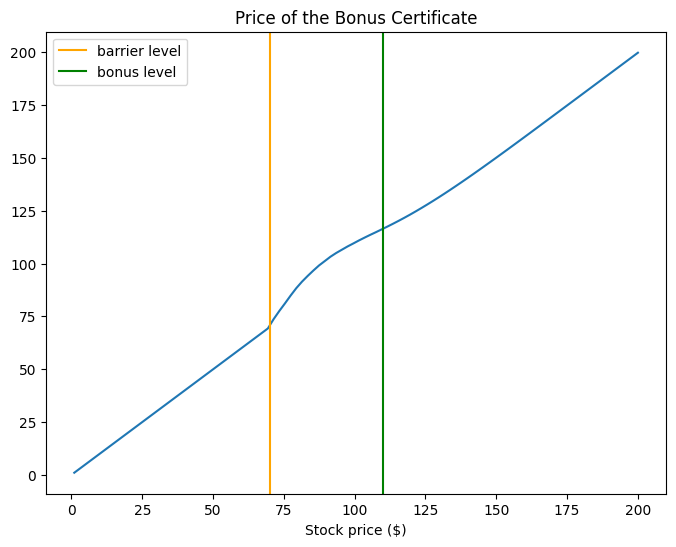

In [ ]:
s = np.linspace(1.0,200.0,100)
v = np.array([round(heston_model(s,0.25**2,w,1,70,110),3) for s in s])
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(s,v)

ax.set_xlabel("Stock price ($)")
ax.set_title("Price of the Bonus Certificate")
ax.axvline(x = 70, color = 'orange', label = 'barrier level')
ax.axvline(x = 110, color = 'green', label = 'bonus level')
ax.legend()

To compute Greeks, we use the finite differences method with $\epsilon\in\{0.05,0.1,0.5\}$, and all the data are filtered with the Savitzky-Golay algorithm.

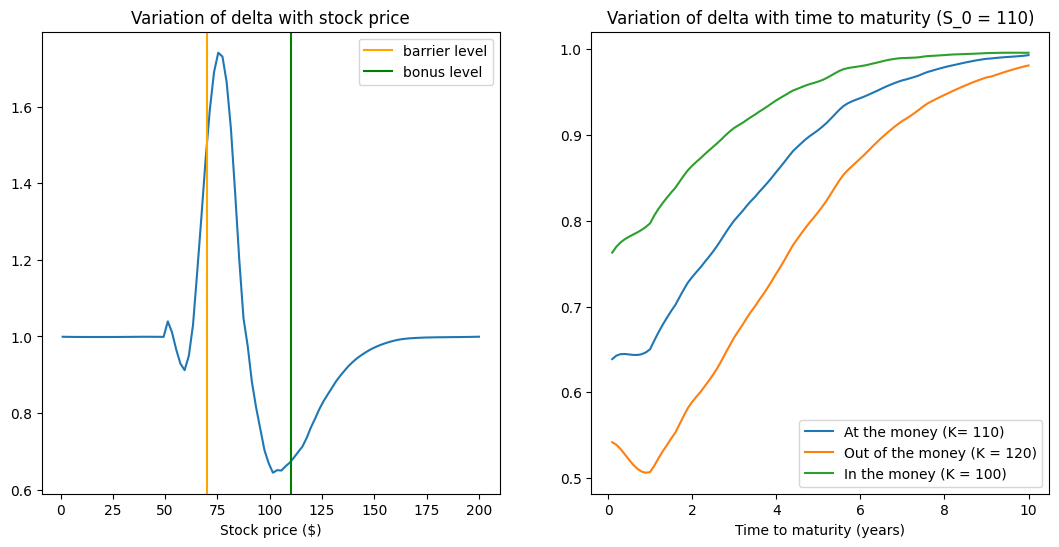

In [ ]:
epsilon = 0.5
s = np.linspace(1.0,200.0,100)
time = np.linspace(0.1,10,100)
v1 = np.array([round(heston_model(s+epsilon,0.25**2,w,1,70,110),3) for s in s])
v2 = np.array([round(heston_model(s-epsilon,0.25**2,w,1,70,110),3) for s in s])
fig,(ax1,ax2) = plt.subplots(ncols = 2, figsize = (13,6))

ax1.plot(s,savgol_filter((v1-v2)/(2*epsilon),20,4))
ax1.axvline(x = 70, color = 'orange', label = 'barrier level')
ax1.axvline(x = 110, color = 'green', label = 'bonus level')

ax1.set_xlabel("Stock price ($)")
ax1.set_title("Variation of delta with stock price")
ax1.legend()


ax2.plot(time, savgol_filter(np.array([round((heston_model(110.0+epsilon,0.25**2,w,t,70,110)-heston_model(110.0-epsilon,0.25**2,w,t,70,110))/(2*epsilon),3) for t in time]),20,4),label = "At the money (K= 110)")
ax2.plot(time, savgol_filter(np.array([round((heston_model(110.0+epsilon,0.25**2,w,t,70,120)-heston_model(110.0-epsilon,0.25**2,w,t,70,120))/(2*epsilon),3) for t in time]),20,4),label = "Out of the money (K = 120)")
ax2.plot(time, savgol_filter(np.array([round((heston_model(110.0+epsilon,0.25**2,w,t,70,100)-heston_model(110.0-epsilon,0.25**2,w,t,70,100))/(2*epsilon),3) for t in time]),20,4),label = "In the money (K = 100)")

ax2.set_xlabel("Time to maturity (years)")
ax2.set_title("Variation of delta with time to maturity (S_0 = 110)")

ax2.legend()

<ipython-input-1-35b957c50cf4>:33: RuntimeWarning: overflow encountered in multiply
  payoff = np.exp(-r*T)*(S[:, -1] + np.maximum(K_DOP - S[:, -1], 0) * (1 - c) * d)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


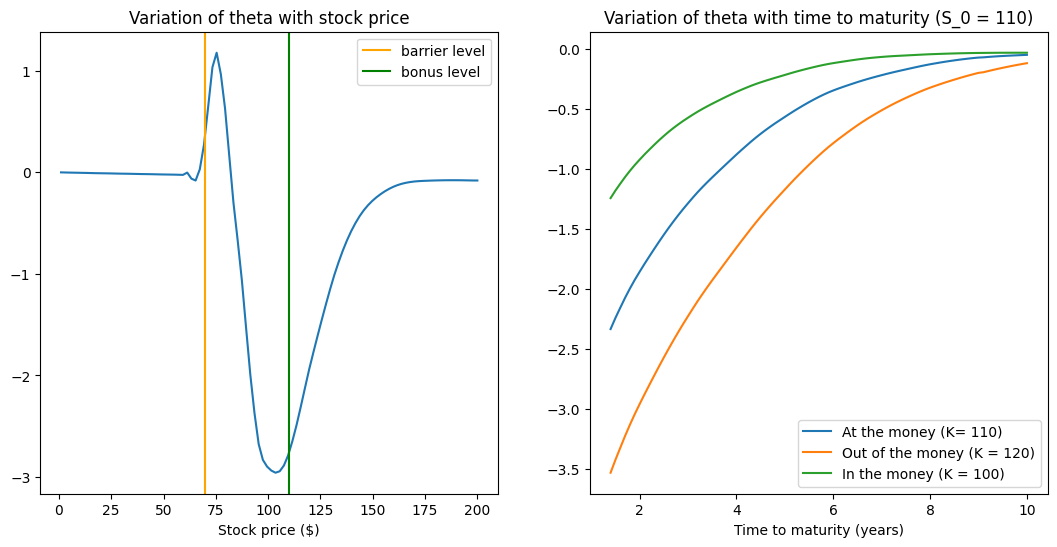

In [ ]:
#Theta
epsilon = 0.5
s = np.linspace(1.0,200.0,100)
time = np.linspace(0.1,10,100)
fig,(ax1,ax2) = plt.subplots(ncols = 2, figsize = (13,6))

ax1.plot(s, savgol_filter(np.array([round((heston_model(s,0.25**2,w,1+epsilon,70,110)-heston_model(s,0.25**2,w,1-epsilon,70,110))/(2*epsilon),3) for s in s]),10,4))
ax1.axvline(x = 70, color = 'orange', label = 'barrier level')
ax1.axvline(x = 110, color = 'green', label = 'bonus level')

ax1.set_xlabel("Stock price ($)")
ax1.set_title("Variation of theta with stock price")

ax1.legend()

ax2.plot(time, savgol_filter(np.array([round((heston_model(110.0,0.25**2,w,t+epsilon,70,110)-heston_model(110.0,0.25**2,w,t-epsilon,70,110))/(2*epsilon),3) for t in time]),20,4),label = "At the money (K= 110)")
ax2.plot(time, savgol_filter(np.array([round((heston_model(110.0,0.25**2,w,t+epsilon,70,120)-heston_model(110.0,0.25**2,w,t-epsilon,70,120))/(2*epsilon),3) for t in time]),20,4),label = "Out of the money (K = 120)")
ax2.plot(time, savgol_filter(np.array([round((heston_model(110.0,0.25**2,w,t+epsilon,70,100)-heston_model(110.0,0.25**2,w,t-epsilon,70,100))/(2*epsilon),3) for t in time]),20,4),label = "In the money (K = 100)")

ax2.set_xlabel("Time to maturity (years)")
ax2.set_title("Variation of theta with time to maturity (S_0 = 110)")

ax2.legend()

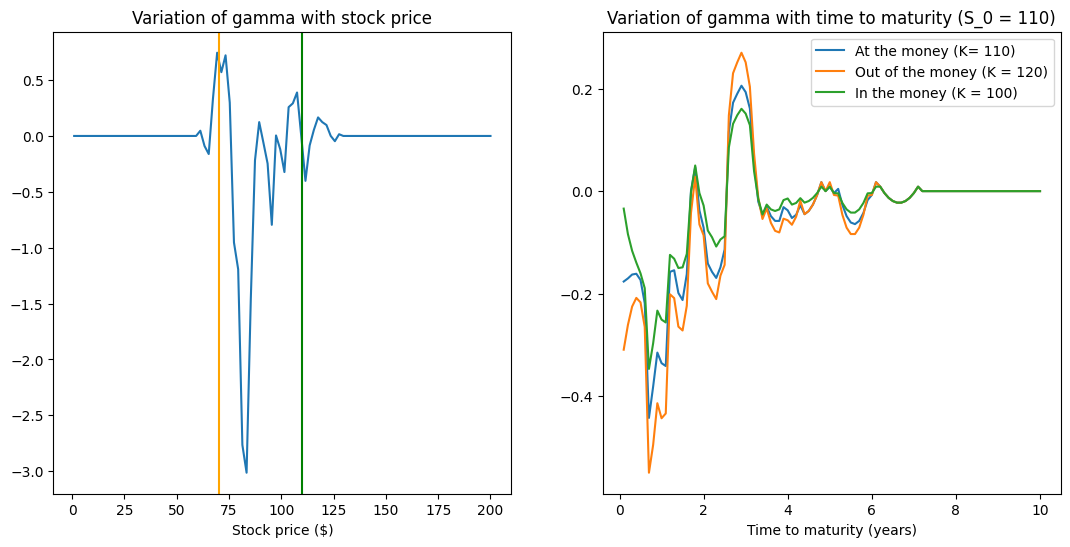

In [ ]:
#Gamma
epsilon = 0.1
s = np.linspace(1.0,200.0,100)
time = np.linspace(0.1,10,100)
fig,(ax1,ax2) = plt.subplots(ncols = 2, figsize = (13,6))

ax1.plot(s,savgol_filter((np.array([round(heston_model(s+epsilon,0.25**2,w,1,70,110)+heston_model(s-epsilon,0.25**2,w,1,70,110)-2*heston_model(s,0.25**2,w,1,70,110),3)/(epsilon**2) for s in s])),10,5))
ax1.axvline(x = 70, color = 'orange', label = 'barrier level')
ax1.axvline(x = 110, color = 'green', label = 'bonus level')

ax1.set_xlabel("Stock price ($)")
ax1.set_title("Variation of gamma with stock price")


ax2.plot(time, savgol_filter((np.array([round(heston_model(110.0+epsilon,0.25**2,w,time,70,110)+heston_model(110.0-epsilon,0.25**2,w,time,70,110)-2*heston_model(110.0,0.25**2,w,time,70,110),3)/(epsilon**2) for time in time])),10,3),label = "At the money (K= 110)")
ax2.plot(time, savgol_filter((np.array([round(heston_model(110.0+epsilon,0.25**2,w,time,70,120)+heston_model(110.0-epsilon,0.25**2,w,time,70,120)-2*heston_model(110.0,0.25**2,w,time,70,120),3)/(epsilon**2) for time in time])),10,3),label = "Out of the money (K = 120)")
ax2.plot(time, savgol_filter((np.array([round(heston_model(110.0+epsilon,0.25**2,w,time,70,100)+heston_model(110.0-epsilon,0.25**2,w,time,70,100)-2*heston_model(110.0,0.25**2,w,time,70,100),3)/(epsilon**2) for time in time])),10,3),label = "In the money (K = 100)")

ax2.set_xlabel("Time to maturity (years)")
ax2.set_title("Variation of gamma with time to maturity (S_0 = 110)")

ax2.legend()



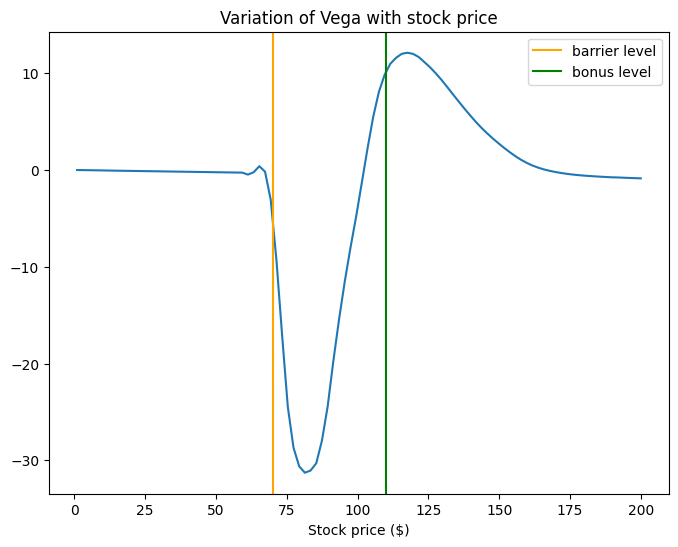

In [ ]:
#Vega
epsilon = 0.05
s = np.linspace(1.0,200.0,100)
time = np.linspace(0.1,10,100)
fig,(ax1) = plt.subplots(ncols = 1, figsize = (8,6))

ax1.plot(s, savgol_filter(np.array([round((heston_model(s,(0.25+epsilon)**2,w,1,70,110)-heston_model(s,(0.25-epsilon)**2,w,1,70,110))/(2*epsilon),3) for s in s]),10,4))
ax1.axvline(x = 70, color = 'orange', label = 'barrier level')
ax1.axvline(x = 110, color = 'green', label = 'bonus level')

ax1.set_xlabel("Stock price ($)")
ax1.set_title("Variation of Vega with stock price")
ax1.legend()




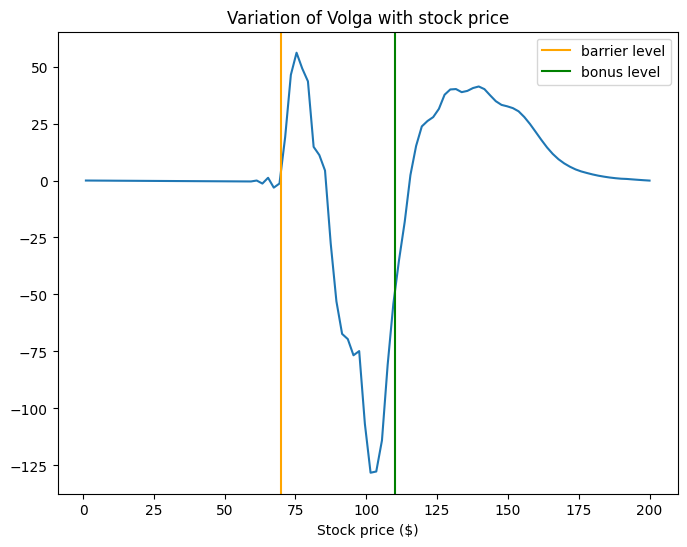

In [ ]:
#Volga
epsilon = 0.05
s = np.linspace(1.0,200.0,100)
fig,(ax1) = plt.subplots(ncols = 1, figsize = (8,6))

ax1.plot(s, savgol_filter(np.array([round((heston_model(s,(0.25+epsilon)**2,w,1,70,110)+heston_model(s,(0.25-epsilon)**2,w,1,70,110)-2*heston_model(s,0.25**2,w,1,70,110))/(epsilon**2),3) for s in s]),10,4))
ax1.axvline(x = 70, color = 'orange', label = 'barrier level')
ax1.axvline(x = 110, color = 'green', label = 'bonus level')

ax1.set_xlabel("Stock price ($)")
ax1.set_title("Variation of Volga with stock price")

ax1.legend()

